# French Pastries, Baseball Players, and Marginal Utility

**Author:** Eric Daub, Alan Turing Institute (Github: @edaub)

## Introduction

I was recently chatting with a friend about the respective merits of the French pastries available at our local bakery:

**Friend:** What do you think of the pastries? Are they good?\
**Me:** Yes, though there is another bakery further out of town that I prefer.\
**Friend:** You don't think these are as good?\
**Me:** No, but not so much worse that I'd walk a half hour each way to get those since I don't have a car. They are definitely better than the ones you get at Pret A Manger which you can find in every train station and city center, so definitely well above a replacement level crossaint.\
**Friend:** What do you mean by that, replacement level?\
**Me:** Oh, it's a term that baseball statisticians use to measure if it's worth paying money for a particular player. The idea is to come up with some baseline that's easily available, and then try to determine how much better something is than that. Economists call this "Marginal Utility."\
**Friend:** [Silence]\
**Me:** [To myself] Did I really just say "replacement level crossaint?"

While I took a course in Economics when I was an undergraduate, I definitely did not completely understand the concept of Marginal Utility until I started reading more about baseball statistics (no doubt beginning with my dog-eared copy of *Moneyball* by Michael Lewis). The idea is that to compare two goods that have different prices, I need to determine how much additional value I get out of the more expensive one to justify the extra expense. Regarding crossaints, the extra cost of the better bakery was my time, which I determined would be better spent doing something else and thus the marginal utility of the fancier bakery was not worth it.

The undergraduate version of me certainly nodded when the professor talked about this in class, as it sounds simple enough. But what I failed to appreciate back then is the idea that to really understand value in some absolute sense, we need to compare these things to some baseline level that I can always acquire without any effort and minimal expense, something that the baseball statisticians were able to very clearly articulate. In terms of pastries, this was the fare available at the Pret just around the corner -- always available for 2 pounds no matter where I am without having to walk a long way, always the same product as they are no doubt churned out en masse at some factory bakery.

## Replacement Level

In baseball, this baseline level is referred to as "replacement level." Conceptually, replacement level does not refer to any player in particular, but rather some theoretical player that any team can acquire at any time with minimal effort (either time or money). We can think of these players as being effectively in infinite supply (by infinite, what we really mean is that "there are far more players of this caliber than there are jobs available on Major League Baseball teams"). If we put a bunch of these theoretical players on the field and played 162 games (a full MLB season), they would not be a particularly good team, but they would be cheap. To win more games than this theoretical team would win, I need to spend some additional time or money in finding players that are better than this replacement level.

One thing to note is that this level is *not* the average of all players in the league -- presumably all of the teams have made considerable effort to spend resources to make their team better, so the league average will reflect some amount of value above this level. How much more valuable is an average player than a replacement level? Most statisticians put replacement level at around 80% of the league average (see for instance the [Wikipedia page](https://en.wikipedia.org/wiki/Wins_Above_Replacement)).

On face, this all seems quite sensible. But recently, I asked myself: why is this a reasonable level? Why 80%? Why not 25%, or 95%? And can we be more precise about *why* 80% represents this "easily findable value" and what it really means in a statistical sense? In the following analysis, I try to tease out what this number really means for MLB hitters.

## Data

In this story, I use the publically available and widely used [Lahman Baseball Database](http://www.seanlahman.com/baseball-archive/statistics). This database is known for its full coverage of most of MLB history, and includes all of the standard batting and pitching statistics for all players for all seasons. It is maintained by a group of volunteers who tabulate statistics and have gone through past newspaper archives to collect the extensive data that it contains. It is available in a number of SQL formats, as well as the raw CSV files, and is updated every year.

In the following, I will use the SQLite version of the database that runs through the 2019 season (it can be found [here](https://github.com/WebucatorTraining/lahman-baseball-mysql/raw/master/lahmansbaseballdb.sqlite)). I choose this mostly because Python has built-in support for SQLite, and since I will be using this database as a standalone data source, I don't have to worry about setting up a server, dealing with concurrent users, or modifying the database.

The tables of the Lahman database are described in the [documentation](http://www.seanlahman.com/files/database/readme2017.txt). I will mainly be using the `batting` table, which contains the relevant hitting statistics and can easily be queried to pull out the specific data that I need to perform this analysis.

In [1]:
%matplotlib inline

In [2]:
import pandas
import numpy as np
import sqlite3
import scipy.stats
import matplotlib.pyplot as plt

conn = sqlite3.connect("lahmansbaseballdb.sqlite")
year = 2019

Once I have connected to the database, I can query the `batting` table to get the full statistics for all hitters that registered at least 10 at bats in the most recent full season (2019) and load into a data frame using pandas:

In [3]:
df = pandas.read_sql('select * from batting where yearID = {} and AB > 10'.format(year), conn)
df.head()

,ID,playerID,yearID,stint,teamID,team_ID,lgID,G,G_batting,AB,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,105864,abreujo02,2019,1,CHA,2900,AL,159,None,634,...,123,2,2,36,152,4,13,0,10,24
1,105865,acunaro01,2019,1,ATL,2897,NL,156,None,626,...,101,37,9,76,188,4,9,0,1,8
2,105866,adamecr01,2019,1,SFN,2920,NL,10,None,22,...,2,0,0,2,8,0,0,0,0,0
3,105867,adamewi01,2019,1,TBA,2922,AL,152,None,531,...,52,4,2,46,153,1,3,3,1,9
4,105874,adamsma01,2019,1,WAS,2925,NL,111,None,310,...,56,0,0,20,115,1,2,0,1,7


This only gives us the raw numbers for these players, and the player is identified with a `playerID` rather than their full name. If I want to get the names, I need to do a join with the `people` table:

In [4]:
df = pandas.read_sql('''select nameLast, nameFirst, AB, H, "2B", "3B", HR, BB
                        from batting inner join people on batting.playerID = people.playerID
                        where yearID = {} and AB > 10'''.format(year), conn)
df.head()

,nameLast,nameFirst,AB,H,2B,3B,HR,BB
0,Abreu,Jose,634,180,38,1,33,36
1,Acuna,Ronald,626,175,22,2,41,76
2,Adames,Cristhian,22,7,1,0,0,2
3,Adames,Willy,531,135,25,1,20,46
4,Adams,Matt,310,70,14,0,20,20


However, most of the time I will just be doing the same query of the `batting` table to pull out hitting statistics, and since I'd like to look at the distribution of outcomes over the entire league, I don't particularly care which players are which. However, I would like to look only at position players, so for the query that I need I will need to do a join on the `appearances` table, which lists how many games a player appeared as a pitcher to exclude pitchers from the analysis.

## Runs Created

At a basic level, baseball comes down to two things: runs and outs. Outs occur when a player fails to hit the ball. Each game consists of 27 outs per team, so the basic goal is to not make outs. If a player does not make an out, then there are several possible outcomes: the player can safely hit the ball somewhere, which allows the player and the player's teammates to advance around the bases a certain amount, or the player can be awarded a base without getting a hit (either through what is known as a walk, also known as "base on balls (BB)," or be awarded a base because the pitcher threw the ball and it struck the hitter). Hits are known as "singles," "doubles (2B)," "triples (3B)," or "home runs (HR)," which advance the batter 1, 2, 3, or 4 bases, respectively (aside: hits tend to advance any teammates already on the bases a different number of bases, but it turns out that the metric below does a reasonable job of accounting for this). Any player that advances 4 bases reaches "home" and scores a run. The team that scores the most runs within the allotted 27 outs wins.

While the main goal is to not make outs, hitters that are more likely to advance players by more than one base at a time are more likely to create more runs, as if they have other players already on the bases, they are more likely to score runs. The simplest way that we can account for this is through a metric known as "Runs Created," which was designed by the legendary baseball statistician Bill James and tries to approximate the number of runs that a player is likely to have produced through their hitting ability. The formula is

$$RC = {\rm Success\: rate}\times{\rm Total\: bases} = \frac{H+BB}{PA}\times TB$$

Here, $H$ is the number of hits, $BB$ is the number of walks, $PA$ is the number of attempts, and $TB$ is the total number of bases. Note that this is a counting stat, not a rate stat, so this number will be larger for someone who plays more games (and thus contributes more overall value) than an equivalent player that played fewer games.

I can pull out the basic statistics that I need to compute Runs Created with the following SQL query, which I will wrap in a function for convenient further use. As mentioned above, to exclude pitchers I need to join on the `appearances` table, which allows me to filter out the pitchers and just focus on position players in this analysis.

In [5]:
def rc_base_query(year, conn):
    "Base query for getting statistics for computing Runs Created"
    
    return pandas.read_sql('''select AB + BB + coalesce(IBB,0) + HBP + SH + coalesce(SF,0) as PA,
                                     AB + SH + coalesce(SF, 0) - H as O,
                                     H - "2B" - "3B" - HR + BB + coalesce(IBB,0) + HBP as S,
                                     "2B",
                                     "3B",
                                     "HR"
                                     from batting inner join appearances on batting.playerID = appearances.playerID
                                     and batting.yearID = appearances.yearID
                                     where batting.yearID = {} and AB > 10 and appearances.G_p < 3'''.format(year),
                           conn)

rc_base_query(year, conn).head()

,PA,O,S,2B,3B,HR
0,627,428,141,33,6,19
1,38,22,11,3,1,1
2,208,130,61,8,0,9
3,78,57,11,4,0,6
4,452,311,121,11,2,7


I generate 6 columns in this query: the total number of attempts (`PA` or "Plate Appearances"), number of outs ("O"), and then 4 additional columns for the types of hits/walks so that I can convert these to the total number of bases. Some statistics, such as sacrifice flies (`SF`) and intentional walks (`IBB`) are not recorded for all years, so I use the SQL `coalesce` function to convert the null values to zero if necessary.

I can generate the Runs Created statistic from this data frame with the following function, which I visualize with a histogram.

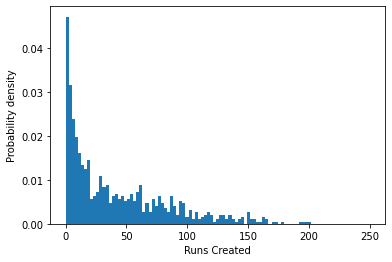

In [6]:
def runs_created(season_stats):
    "computes runs created from a data frame/array holding plate appearances, outs, singles, doubles, triples, and home runs"
    
    if isinstance(season_stats, pandas.DataFrame):
        plate_appearances = season_stats["PA"]
        outs = season_stats["O"]
        singles = season_stats["S"]
        doubles = season_stats["2B"]
        triples = season_stats["3B"]
        home_runs = season_stats["HR"]
    else:
        if df.ndim == 1: # Only the stats of a single player
            season_stats = np.reshape(season_stats, (1, -1))
        plate_appearances = np.sum(season_stats, axis=-1)
        outs = season_stats[:,0]
        singles = season_stats[:,1]
        doubles = season_stats[:,2]
        triples = season_stats[:,3]
        home_runs = season_stats[:,4]
    
    return (1.-outs/plate_appearances)*(singles + 2*doubles + 3*triples + 4*home_runs)

def rc_histogram(*args, scale="linear"):
    "plot a histogram of any number of runs created arrays/sequences on a linear or logarithmic scale"
    
    for rc in args:
        if scale == "log":
            dist = np.log(runs_created(rc))/np.log(10.)
            bins = np.linspace(-1., 3., 100)
        else:
            dist = runs_created(rc)
            bins = np.linspace(0, 250, 100)
        plt.hist(dist, bins=bins, density=True)
    if scale == "log":
        plt.xlabel("Log Runs Created")
    else:
        plt.xlabel("Runs Created")
    plt.ylabel("Probability density")

season_stats = rc_base_query(year, conn)
rc_histogram(season_stats)

As we can see, there is a significant spike near zero, and then the numbers fall off as we move out beyond 100 and up to around 200. In general, creating more than 100 runs indicates that a player is very good.

As an aside, the raw numbers here are illustrative of the general idea behind using Runs Created to measure a player's ability, but this simple version does not account for a number of well-known additional effects:

* For one, a single and a walk are treated the same, but we know that singles have the potential to move runners more than one base, while a walk cannot.
* We also have not corrected for the fact that different stadiums tend to produce more runs than others, so a player that has half of their opportunities in a stadium that is friendly to hitters will get a boost for which a correction can be made.
* One final, and more subtle issue, is the fact that the best players will be overvalued here because they cannot get on base for themselves (i.e. a player that is significantly better than their teammates will have fewer people on base than would be expected from the average).

More sophisticated techniques are needed to treat these effects, but won't change the overall way that we convert this distribution into a replacement level value, so we will ingore these additional effects going forwards. As mentioned earlier, a good first estimate of replacement level can be found by taking 80% of the mean, so from these calculations we can estimate replacement level:

In [7]:
def empirical_replacement_level(season_stats):
    "calculate empirical replacement level statistic using 80% heuristic"
    return 0.8*np.mean(runs_created(season_stats))

print("Basic replacement level for {}: {}".format(year, empirical_replacement_level(season_stats)))

Basic replacement level for 2019: 33.44446765167918


This suggests that creating 40 runs is a good baseline for comparison for a position player. However, it is not clear why this is the case. The distribution is strongly peaked near zero, then falls off around 10 RC -- why is that not considered replacement level? Or for that matter, if the peak is near zero, then why isn't creating any runs at all above replacement? The tail of the distribution is also quite heavy, with small numbers of players producing lots of runs. Are these players really so much better than the others, or is this just luck? To address this, we need a way to simulate the season many times to estimate what we expect this distribution to look like with more samples so that we can scrutinize it in more depth.

## Multinomial Bayesian Inference

To simulate many versions of the same season, we turn to Bayesian Inference. Bayesian models treat their parameter values as probability distributions, which allows us to quantify the uncertainty in the underlying model and propagate that uncertainty forward in additional simulations. Formally, we treat each parameter $\theta$ in the model as a probability distribution, and seek to compute the posterior probability conditioned on the data $y$, $p(\theta|y)$. Computing this probability is done via Bayes' Rule:

$$p(\theta|y) = \frac{p(y|\theta)p(\theta)}{p(y)}$$

$p(y|\theta)$ here is the likelihood, or the probability of the data given a particular value of the model parameters. $p(\theta)$ is the prior, our initial beliefs about reasonable values of the parameter. $p(y)$ is known as the evidence, and is the probability of getting the data over all possible realizations of the experiment. This rule lets us convert the likelihood, which is generally more straightforward to compute to the posterior by weighting it using the prior and evidence.

### Multinomial Distribution

What model might we use to describe a hitter? At the most basic level, we can think of a hitter as a set of probabilities that they will make an out, hit a single, hit a double, etc. Thus, a set of five probabilities that sum to 1 is a straightforward way of capturing the abilities of a hitter. Once we have those five probabilities, the outcome of a series of hitting attempts is described by a Multinomial distribution.

For example, if I am a hitter and I have a 60% chance of making an out, a 30% chance of hitting a single/drawing a walk, 5% chance of hitting a double, 1% chance of hitting a triple, and 4% chance of hitting a hume run, then if I come up to bat 100 times I would expect the following distribution of outcomes:

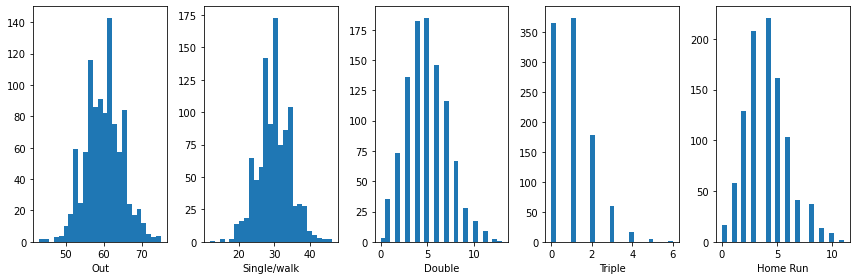

In [8]:
def plot_multiple_distributions(samples):
    "make a plot of multiple components of probability samples"
    
    assert samples.shape[-1] == 5, "samples must have 5 components"
    
    labels = ["Out", "Single/walk", "Double", "Triple", "Home Run"]
    
    plt.figure(figsize=(12,4))
    
    for i in range(5):
        plt.subplot(int("15"+str(i+1)))
        plt.hist(samples[:,i], bins=25)
        plt.xlabel(labels[i])
        
    plt.tight_layout()

def plot_multinomial(n_samples, n_trials, p):
    "plot the distribution of outcomes from a set of multinomial trials"
    
    assert n_samples > 0, "number of samples must be greater than zero"
    assert n_trials > 0, "number of trials must be greater than zero"
    assert p.ndim == 1, "p must be a 1D array"
    assert np.all(p >= 0.) and np.sum(p) == 1., "all probabilities must be positive and sum to 1"
    
    samples = scipy.stats.multinomial.rvs(n=n_trials, p=p, size=n_samples)
    plot_multiple_distributions(samples)
    
hypothetical_player_probs = np.array([0.6, 0.3, 0.05, 0.01, 0.04])
plot_multinomial(1000, 100, hypothetical_player_probs)

Thus, if I repeated my hypothetical set of 100 hitting attemps many times, this shows the range of outcomes I might expect.

### Prior

Now I need to specify my prior beliefs about what I probabilities I might expect a hitter to have before I see any data. One natural way to handle this is a Dirichlet distribution, which has the nice property that it plays nicely with a multinomial distribution and gives me an analytical way to compute the posterior. A Dirichlet distribution is a generalization of the Beta distribution in multiple dimensions (in this case, 5 as we need our 5 probabilities for our multinomial distribution).

A Beta distribution takes 2 parameters, while an $n$-dimensional Dirichlet distribution takes $n$ parameters, usually referred to as $\alpha$. As with the beta distribution, if the parameters are small the probability density is concentrated towards one outcome being more likely, while if the weights are large then probability density is more even across the different dimensions. Combining small and large values let us tweak the distribution in a wide range of different ways, giving plenty of flexibility in describing our prior beliefs.

For this model, I am going to specify a prior that is rather pessimistic about a player's ability, thus the probabilities should be large for making an out, and relatively small for the more valuable hits. Only once a player shows sustained ability to do better than this threshold will I have more faith in their run producing capabilities. (One caveat here is that I need to be sure at the end of my analysis that my estimation of replacement level is significantly higher than this level, so this is one thing to look out for!)

The following illustrates the priors that I use in my analysis:

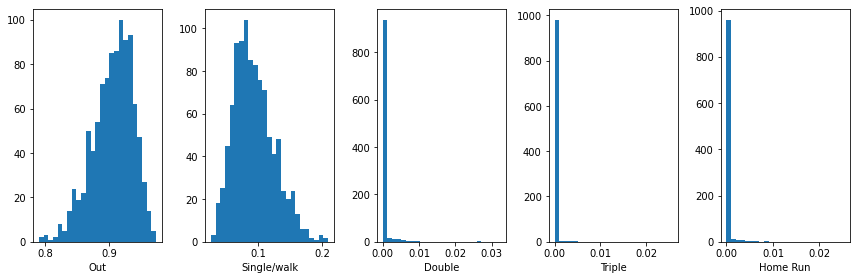

In [9]:
def plot_dirichlet(n_samples, alpha):
    "plot samples of the probabilities drawn from a Dirichlet distribution"
    
    assert n_samples > 0, "number of samples must be greater than zero"
    assert np.all(alpha > 0), "all alpha components must be positive"
    
    samples = scipy.stats.dirichlet.rvs(alpha, size=n_samples)
    
    plot_multiple_distributions(samples)

priors = np.array([80., 8., 0.04, 0.01, 0.02])
plot_dirichlet(1000, priors)

### Posterior

As noted above, if I use a Dirichlet prior, I can compute the posterior analytically. In this case, the posterior is also a Dirichlet distribution, but with the $\alpha$ parameters summed with the number of observations of each of the outcomes. In this way, if the absolute number of outcomes is high the posterior weights will reflect that of the data, while if there are only a few observations the prior will still hold some sway over the distribution. Thus, if I take my hypothetical player described above with 100 plate appearances, the posterior given a particular set of observations will be:

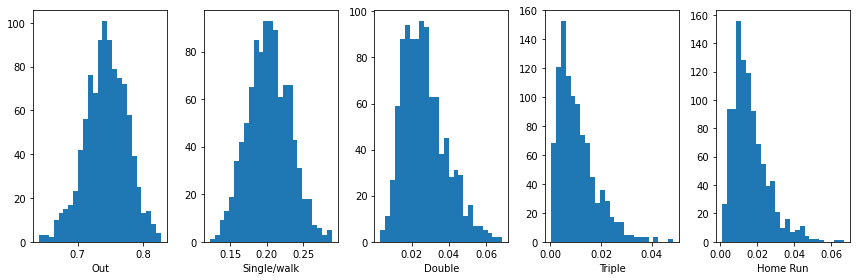

In [10]:
hypothetical_player_stats = scipy.stats.multinomial.rvs(size=1, n=100, p=hypothetical_player_probs).flatten()

plot_dirichlet(1000, priors + hypothetical_player_stats)

### Simulating full seasons using the posterior

Given the posterior samples, we can use these samples from the posterior of the probabilities describing this player to project their performance over a full season (say over 600 plate appearances, a typical number for someone that plays a full season):

In [11]:
def project_player_season(player_stats, n_samples, plate_appearances, prior):
    "project multiple samples from the season of a player given their stats"
    
    assert n_samples > 0, "number of samples must be greater than zero"
    assert plate_appearances > 0, "number of plate appearances must be greater than zero"
    assert player_stats.shape == (5,), "player stats must be a 1D array of length 5"
    assert np.all(player_stats >= 0), "player stats must be non-negative integers"
    assert np.all(prior > 0.), "all prior weights must be greater than zero"
    
    outcomes = np.zeros((n_samples, n_samples, 5), dtype=np.int64)
    samples = scipy.stats.dirichlet.rvs(alpha=prior + player_stats, size=n_samples)

    # occasionally roundoff error causes the sum of these sampled probabilities to be larger than 1
    if np.any(np.sum(samples, axis=-1) > 1.):
        rounded_error = (np.sum(samples, axis=-1) > 1.)
        samples[rounded_error] = (samples[rounded_error]/
                                  (np.sum(samples[rounded_error], axis=-1)[:,np.newaxis] + 1.e-15))
    
    for i in range(n_samples):
        outcomes[i] = scipy.stats.multinomial.rvs(n=plate_appearances, p=samples[i], size=n_samples)
        
    return np.reshape(outcomes, (-1, 5))

full_season_pa = 600
print("Hypothetical {} plate appearance season [Outs, Singles/Walks, Doubles, Triples, Home Runs]: {}".format(
    full_season_pa, project_player_season(hypothetical_player_stats, 1, full_season_pa, priors)[0]))

Hypothetical 600 plate appearance season [Outs, Singles/Walks, Doubles, Triples, Home Runs]: [438 134  10   3  15]


With all of this, we are now in a position to simulate the Runs Created over many hypothetical seasons to see the variation in the value this hypothetical player:

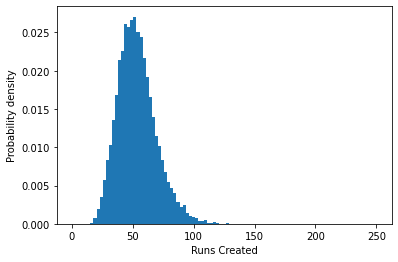

In [12]:
hypothetical_player_seasons = project_player_season(hypothetical_player_stats, 100, full_season_pa, priors)
rc_histogram(hypothetical_player_seasons)

From this, we can see that after 100 chances, we still have quite a bit of uncertainty about how well a player will perform over an entire season.

## Simulating League Seasons

Now we can do this for every player in the 2019 season to see what the full league-wide distribution is expected to be if every player had the same number of at bats. Since this number may fluctuate over the years, we can use the 95th percentile of the actual league value as an estimate of what a typical full season would be for a good player. This should also normalize out the change in number of games in a full season that occurred in 1961 from 154 to 162, which might affect the number of appearances a player had. Once we have simulated this, we can overlay the actual distribution to see what differences we notice.

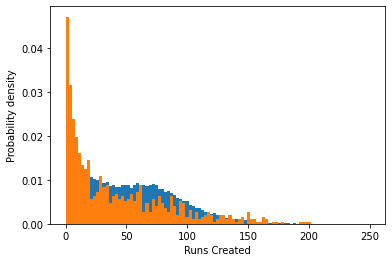

In [13]:
def project_league_season(season_stats, n_samples, plate_appearances, priors):
    
    if isinstance(season_stats, pandas.DataFrame):
        season_stats_array = np.array(season_stats)[:,1:]
    else:
        season_stats_array = season_stats
    
    league_projections = np.zeros((len(season_stats), n_samples*n_samples, 5), dtype=np.int64)
    
    for i in range(len(season_stats)):
        league_projections[i] = project_player_season(season_stats_array[i],
                                                      n_samples, plate_appearances, priors)

    return np.reshape(league_projections, (-1, 5))

def get_baseline_plate_appearances(season_stats, percentile=0.95):
    "Extract the 90th percentile of the given seasons number of plate appearances"
    
    assert percentile > 0. and percentile < 1.
    
    if isinstance(season_stats, pandas.DataFrame):
        plate_appearances = season_stats["PA"]
    else:
        plate_appearances = np.sum(season_stats, axis=-1)
    
    return np.quantile(plate_appearances, percentile)

def project_year(season_stats, stats, n_samples=10):
    "project multiple realizations of a full league season"
    
    full_season_pa = get_baseline_plate_appearances(season_stats)

    return project_league_season(season_stats, n_samples, full_season_pa, priors)

simulated_seasons = project_year(season_stats, priors)
rc_histogram(simulated_seasons, season_stats)

From this, we can see that this simulated distribution has a few differences from the true distribution. Rather than a peak near zero and then a gradual falloff towards higher numbers, we see a second peak out near 70 runs created or so.

Why might we expect this? Well, there are two reasons why the actual distribution might have a peak near zero. The first is that there are many players that are bad that do not produce many runs because they simply are not good hitters. The second is that these players are actually good, but have not produced much value because they had a smaller number of attempts (whether due to injuries, or being forced to share opportunities with another player on their team). By doing a simulation like this, we see that some of these hitters have actually shown evidence that they are decent hitters, but have not gotten enough at bats to contribute significant value. Others within that peak near zero have not provided evidence that they are good, so these are not useful in evaluating if

We can check this by plotting what distribution we would expect if all players' abilities were drawn from our prior:

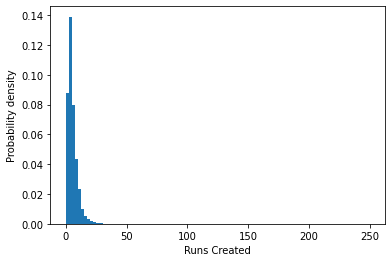

In [14]:
season_prior_level = project_player_season(np.zeros(5, dtype=np.int64), 1000, full_season_pa, priors)
rc_histogram(season_prior_level)

This looks similar to the peak closer to zero in the above simulated distribution, confirming that we have a number of players for which we do not have evidence that they are significantly better than our prior. The remaining players that perform better than this level are thus major league level players that we can be confident have some value. The remaining challenge is thus to find a way to separate these two distributions.

## Approximating the distributions

What form might we expect these distributions to take? One constraint is that we know that Runs Created has to be positive. A commonly used distribution for positive random variables is a Lognormal distribution. It is fairly easy to check if a variable is Lognormal, as we simply can make a histogram with a log horizontal scale and check if the data looks roughly normal on this scale:

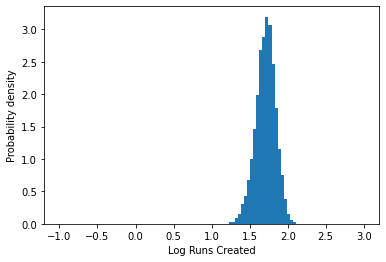

In [15]:
rc_histogram(hypothetical_player_seasons, scale="log")

This looks reasonably symmetric, so fitting a normal distribution to the data on a log scale is probably a reasonble way to roughly estimate what this distribution looks like. We can try the same thing for the prior data:

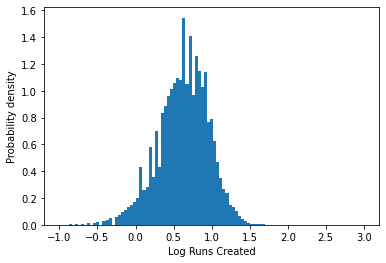

In [16]:
rc_histogram(season_prior_level, scale="log")

This looks reasonably symmetric too, though there may be some issues with aliasing due to the integer nature of some of the underlying statistics. While I might dig into the log-normality of these distributions more carefully, for the sake of this analysis this is probably a reasonable approximation to make.

### Bayesian Gaussian Mixture Models

To separate out the two parts of the distribution, I will fit a Gaussian Mixture Model to the data on a logarithmic scale. A Gaussian Mixture Model approximates a probability distribution as the sum of several Normal distributions, allowing us to tease out the two components by scrutinizing the parameters of the two distributions. I can fit this type of model readily using the Scikit-Learn package:

In [17]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def fit_mixture_model(simulated_seasons):
    "Fit a Gaussian Mixture model to the given season"
    
    rc = runs_created(simulated_seasons)
    rc = np.reshape(rc[rc > 0.], (-1, 1))
    
    return BayesianGaussianMixture(n_components=2).fit(np.log(rc)/np.log(10.))

gmm = fit_mixture_model(simulated_seasons)

I occasionally get `ConvergenceWarning`s when fitting this model. Further inspection has shown that these models usually seem to make reasonable predictions, so for the sake of clean presentation I suppress such warnings here. We can plot the mixture model on top of the data to which it has been fit as follows:

Means: [1.3187522  1.86005294]
Variances: [0.15292841 0.0253339 ]


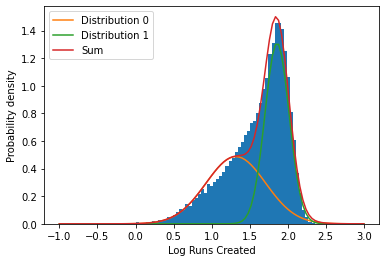

In [18]:
def get_normal_from_gmm(gmm, index):
    "converts gmm model to callable pdf function"
    
    assert index == 0 or index == 1
    
    def norm_pdf(x):
        return(np.squeeze(gmm.weights_)[index]*
               scipy.stats.norm.pdf(x, loc=np.squeeze(gmm.means_)[index],
                                    scale=np.sqrt(np.squeeze(gmm.covariances_)[index])))
    
    return norm_pdf

def plot_distribution_sum(simulated_seasons):
    "plot the Gaussian mixture models with the underlying data"
    
    rc_histogram(simulated_seasons, scale="log")
    
    gmm = fit_mixture_model(simulated_seasons)

    pdf0 = get_normal_from_gmm(gmm, 0)
    pdf1 = get_normal_from_gmm(gmm, 1)
    logrc_vals = np.linspace(-1., 3., 101)
    
    plt.plot(logrc_vals, pdf0(logrc_vals), label="Distribution 0")
    plt.plot(logrc_vals, pdf1(logrc_vals), label="Distribution 1")
    plt.plot(logrc_vals, pdf0(logrc_vals)+pdf1(logrc_vals), label="Sum")
    plt.legend()

    print("Means: {}".format(np.squeeze(gmm.means_)))
    print("Variances: {}".format(np.squeeze(gmm.covariances_)))
    
plot_distribution_sum(simulated_seasons)

We see that the Gaussian Mixture Model was able to fit the two components, which do a reasonable (though imperfect, as we can see that the sum of the two distributions does not perfectly match the data between the two peaks). Also we note that the lower distribution appears to be shifted to the right relative to what would be expected for the prior, suggesting that this lower part of the distribution is not just comprised of players with small numbers of plate appearances. However, we will see that the resulting distributions can still be used to give us a reliable estimate of replacement level.

Now we can finally interrogate the distribution of player performances over a full season for which we have ample evidence they are better than our pessimistic prior. This can give us a more precise, technical answer to the question we posed earlier about what "replacement level" really means: we can say that based on our model, a particular number of runs is a certain number of standard deviations below the mean performance of a typical major league player. Since in 2019 there were 30 teams, each with roughly 15 position players, then the lowest 2.5% of those (i.e. 2 standard deviations below the mean) would roughly be the 13 worst players in the major leagues. This seems like a reasonable first pass at a definition of replacement level:

In [19]:
def extract_replacement_level(gmm, threshold=0.025):
    "Determine the runs created for every day players below a certain threshold"
    
    assert threshold > 0., "threshold must be positive"
    assert threshold < 1., "threshold must be less than 1"

    if gmm.means_[1][0] > gmm.means_[0][0]:
        idx = 1
    else:
        idx = 0

    level = scipy.stats.norm.ppf(threshold)
    
    return 10.**(gmm.means_[idx][0]+level*np.sqrt(gmm.covariances_[idx][0][0]))

print("Estimated replacement level: {}".format(extract_replacement_level(gmm)))
print("Empirical replacement level: {}".format(empirical_replacement_level(season_stats)))

Estimated replacement level: 35.32348261950997
Empirical replacement level: 33.44446765167918


This is not too far off the empirical heuristic, but thanks to all of our modelling above, we have a more precise definition of what we mean by this. We can repeat this over many seasons to see how this baseline level varies over time by wrapping the replacement level calculations up in functions and repeating over the full modern history of baseball.

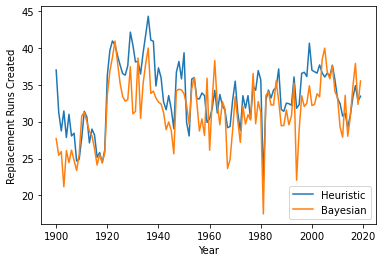

In [20]:
def bayesian_replacement_level(year, conn, priors, threshold=0.025):
    "Full function for Bayesian replacement level estimation"
    
    season_stats = rc_base_query(year, conn)
    
    league_season = project_year(season_stats, priors)
    
    gmm = fit_mixture_model(league_season)
    
    return extract_replacement_level(gmm, threshold)

def heuristic_replacement_level(year, conn):
    "full function for heuristic replacement level calculation"
    
    season_stats = rc_base_query(year, conn)
    
    return empirical_replacement_level(season_stats)

def make_time_plot(start, end, conn):
    "plot the evolution of estimates for replacement level over time"

    start = int(start)
    end = int(end)
    
    years = np.arange(start, end)
    
    heuristic_estimates = [heuristic_replacement_level(yr, conn) for yr in years]
    bayesian_estimates = [bayesian_replacement_level(yr, conn, priors) for yr in years]

    plt.plot(years, heuristic_estimates, label="Heuristic")
    plt.plot(years, bayesian_estimates, label="Bayesian")
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Replacement Runs Created")
    
make_time_plot(1900, 2020, conn)

As we can see, this method gives similar estimates of replacement level over the course of the history of baseball to the traditional heuristic. We see that it captures the overall trends in run production that we expect -- runs were scarce in the "dead ball" era prior to 1920, then show an uptick, a decrease in the 1940's that holds fairly stable until an increase in the late 1990's and early 2000's during the "steriod" era, and a lull again in the 2010's that has since increased again. There are two strike-shortened seasons (1981 and 1994-1995) that stick out where we see a sudden dip in the numbers in the Bayesian model, which is likely due the reduced number of games as Runs Created is a counting stat.

The biggest differences between the two approaches appear to be in the 1920's to 1930's, with the Bayesian model showing a slightly lower estimate of the replacement level than the 80% of the league average heuristic. There is also a discrepancy in the very early 1900's, and the late 1990's shows a spike during the "steriod" era that is not as prominent in the Bayesian model. A deeper investigation would be needed to explore exactly why the Bayesian method does not mirror the changes seen in the heuristic one.

As mentioned above, our estimate of runs created was fairly crude for this analysis. Extending this to be more accurate requires factoring in base running, correcting for the effect of each stadium on run production, and being more precise in how the runs each team scores can be attributed to each player (i.e. the "a player cannot be on base for themselves" effect). Additional things to consider is fielding luck -- more modern data that tracks the ball when it is hit, and corrections can be made for hard hit balls that are likely to have been hits but the defense was positioned correctly to make an out. However, this data is only available for modern play, so projecting these effects over the course of baseball history is not possible.

A similar analysis can be done for a pitchers. Pitchers are fundamentally measured by their ability to get outs and not giving up hits or walks, just with the desired outcomes reversed when compared to hitters. However, much analysis by statisticians have shown that there is significant randomness in the fraction of batted balls that turn into hits versus outs, so the simplest way to study pitchers is to look at the things the pitcher is unequivocally: walks, strikeouts (i.e. the batter was unable to hit the ball), and home runs over a number of innings pitched. This is known as Fielding Independent Pitching (FIP), and can be converted into a number of runs saved. This can then be analyzed in a similar fashion to the runs that a hitter creates to measure pitcher value.

Beyond baseball, measuring marginal utility is more difficult because the value of many things is often subjective and hard to boil down to clear value above a baseline level. For instance, I love getting coffee from my local cafe. Should I be comparing this to coffee I make at home? Get from Starbucks? From the instant machine at my local convenience store? Depending on the circumstance, "available with minimal effort" is highly dependent on context and mood. Until we find a way to quantify that in an objective way, sports will remain one of the most popular avenues to rigorously quantify and analyze marginal utility.